## What is a machine learning research paper?

A machine learning research paper is a scientific paper that details findings of a research group on a specific area.

The contents of a machine learning research paper can vary from paper to paper but they generally follow the structure:

| **Section** | **Contents** |
| ----- | ----- | 
| **Abstract** | An overview/summary of the paper's main findings/contributions. |
| **Introduction** | What's the paper's main problem and details of previous methods used to try and solve it. |
| **Method** | How did the researchers go about conducting their research? For example, what model(s), data sources, training setups were used? |
| **Results** | What are the outcomes of the paper? If a new type of model or training setup was used, how did the results of findings compare to previous works? (this is where **experiment tracking** comes in handy) |
| **Conclusion** | What are the limitations of the suggested methods? What are some next steps for the research community? |
| **References** | What resources/other papers did the researchers look at to build their own body of work? |
| **Appendix** | Are there any extra resources/findings to look at that weren't included in any of the above sections? |

## What we are going to cover?

- Getting Setup

- Introduction machine learning paper replicating weith Pytorch

- Replicating ViT for Foodvisio nMini

- Training ViT

- Feature Exrtaction with pretrained ViT

# PyTorch Paper Replicating

The goal of machine learning research paper replicating is to turn a ML research paper into usable code

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch : https://paperswithcode.com/paper/an-image-is-worth-16x16-words-transformers-1

## Get Setup

Let's import code we've previously written + rquired libaries

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1
torchvision version: 0.15.2


In [18]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import *
    from helper_functions import *
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import *
    from helper_functions import *

In [19]:
!nvidia-smi

Sat Aug 19 11:44:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:26:00.0  On |                  N/A |
|  0%   50C    P5    11W / 170W |    540MiB / 12288MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
# Setup device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Get data 

The whole goal of what we're trying to do is replicate the ViT archiecture for our foodvision mini problem.

To do that, we need some data

Namely the pizza, steak, and sucshi images we've been using so far...

In [21]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [22]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [23]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Create Datasets and DataLoaders

In [25]:
from going_modular.going_modular import *

In [36]:
IMG_SIZE = 224
manual_transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor()
    ]
)
manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [37]:
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    transform=manual_transform,
    batch_size=BATCH_SIZE
)

In [39]:
len(train_dataloader),len(test_dataloader),class_names

(8, 3, ['pizza', 'steak', 'sushi'])

## Visualize Images

In [44]:
imgs,labels = next(iter(train_dataloader))

In [48]:
import random

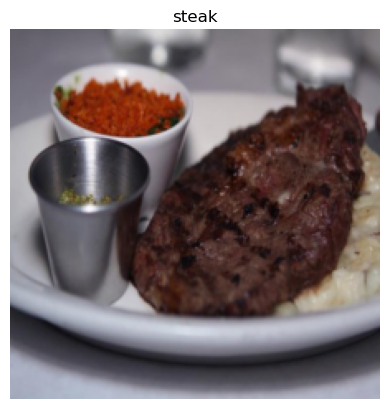

In [62]:
rdm_no = random.randint(0,len(labels)-1)
plt.figure()
plt.imshow(imgs[rdm_no].permute(1,2,0))
plt.title(class_names[labels[rdm_no]])
plt.axis(False)
plt.show()